 # The Impact of London Traffic Pollution Charges on NO2 levels

## Background and project goals
Poor air quality is a huge risk to human health. In London, pollutant levels greatly exceed the World Health Organization's (WHO) recommendations and contribute to thousands of deaths every year. Policies such as traffic congestion charges have been implemented in recent years to try and address this problem. A toxicity charge (T-charge) requiring older, more polluting cars to pay an additional fee to drive in central London, was introduced in October 2017 and replaced by the Ultra Low Emission Zone charge (ULEZ) in 2019. Reports issued by the Mayor of London have presented these traffic schemes as extremely successful at reducing levels of common pollutants such as NO2. In this project we were interested in the effects that traffic pollution charges (T-Charge and ULEZ) might have on air pollution and traffic congestion in 'border sites' - roads just outside the charge zone. More specifically, we tested whether these border roads might have suffered a negative impact as a result of increased use by people who are trying to avoid paying the charge. Additionally, we attempted to replicate previous findings demonstrating that the intervention led to an improvement in air quality within the charge zone.


Map of T-Charge and central London ULEZ borders:

<img src="./images/ULEZ_map.jpg" alt="map" width="400x">

## Methods
To assess the effects of the pollution charges on traffic and air quality, we used air pollution data from the LondonAir website and traffic data published by the department of transport. The present notebook focuses on air pollutaion. 

Our dataset includes daily recordings of the concentrations of NO2, PM2.5 and PM10, air pollutants that are heavily associated with transport. NO2 is produced primarily by the burning of fuel, and is emitted by cars, trucks and busses, leading to high concentrations of NO2 in locations with heavy traffic. Airborne particulate matter (PM) is derived both from natural sources (such as dust and sea salt), and from human-made sources such as particles emitted from vehicle exhausts. It is estimated that half of London’s NO2 pollution and one third of London’s PM pollution is emitted by road transport. 

Data was recorded between 2016-2021, from 75 monitoring sites. To isolate the impact of the traffic pollution charges, we divided the monitoring sites into three locational groups: inside the charge zone, on the border, and outside the charge zone. Sites outside the charge zone were used as a baseline measure for changes in air pollution that are independent of the intervention. Due to an insufficient number of sites monitoring PM2.5 and PM10 concentrations, the analysis presented here focusses on NO2. However, by changing the 'pol_code' value the code in this notebook can be run against other pollutants.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
import scikit_posthocs as sp
from transform_data import *
from sufficient_data_test import *

In [2]:
#define variables
tc_start_date = datetime.date(year = 2017, month = 10, day = 23) # Date traffic T-charge was introduced
ulez_start_date = datetime.date(year = 2019, month = 4, day = 8) # Date ULEZ was introduced

# Maximum values for NO2 as recommended by WHO 
rec_daily_max = 25 
rec_yearly_max = 10

#load the data
file_path = "./cleaned_data" # To run the code update this to the location of data on your computer
# The EDA code can be run on three pollutants: NO2, PM2_5 and PM10. There is only limited data available for PM2_5 and PM10
pol_code = "NO2"
daily, monthly, pre_averages, post_averages, changes = transform_data(pol_code, file_path)

# define pollutant measure name
pollutant_to_measure = {"NO2": "NO2 (ug/m3)", 
                    "PM2_5": "PM2.5 (ug/m3)",
                    "PM10" : "PM10 (ug/m3)"}
pollutant_measure = pollutant_to_measure[pol_code]

In [3]:
# Check if there is enough data to perform the statistical analysis
can_analyse = sufficient_data_test(changes)

There are enough sites in each location to run an analysis on this pollutant


# Data
*daily:* DF containing daily averages of NO2 concentration recordings from all sites

*monthly:* DF containing monthly averages of NO2 concentration recordings. Data is included only for sites with at least 20 days of data recordings that month.

*pre_averages:* DF containing monthly averages of NO2 concentrations during the 6 months before the T-charge was introduced (May - October 2017). Data is included only for sites with at least 4 months of data.

*post_averages:* DF containing monthly averages of NO2 concentrations during the 6 months after ULEZ was introduced (May - October 2019). Data is included only for sites with at least 4 months of data.

| Variable | Description|
|----|------------------|
|site_indicator | unique site identifier|
|weekday | day of the week |
|site_type| type of monitoring site | 
|location| location relative to charge zone (inside, outsde, border)|
|year| year (2016-2021)
| month | month (1-12)|  
| day| day of month (1-31)| 
| is_weekend | binary indicator of weekend | 
| concentration | recorded concentration of pollutant (ug/m3)| 

In [4]:
# Display data types
daily.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 137025 entries, 2016-04-08 to 2021-04-08
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   site_indicator  137025 non-null  object 
 1   weekday         137025 non-null  object 
 2   site_type       137025 non-null  object 
 3   location        137025 non-null  object 
 4   year            137025 non-null  float64
 5   month           137025 non-null  float64
 6   day             137025 non-null  float64
 7   is_weekend      137025 non-null  bool   
 8   concentration   92156 non-null   float64
dtypes: bool(1), float64(4), object(4)
memory usage: 9.5+ MB


In [5]:
#Number of sites according to location
print('Number of sites with daily data by location:')
daily.groupby('location').agg("nunique")["site_indicator"]

Number of sites with daily data by location:


location
inside_border     14
on_border          8
outside_border    53
Name: site_indicator, dtype: int64

# Exploratory Data Analysis - NO2 levels

Air pollution can be affected by many factors outside the intervention such as seasonality and weather. This EDA was performed to improve our understanding of the effects of several variables that we predicted would have a large impact.

### Time related effects on NO2 levels
Time-related effects on air quality were studied by averaging NO2 concentrations across all monitoring sites, regardless of site location. Below, we can see weekly and seasonal trends in NO2 concentrations: levels were higher on weekdays than on the weekend and higher during winter months than summer months. Additionally, levels have decreased over the years.

Text(-1, -20, '*Red horizontal line represents the current WHO guideline for maximum recommended daily mean')

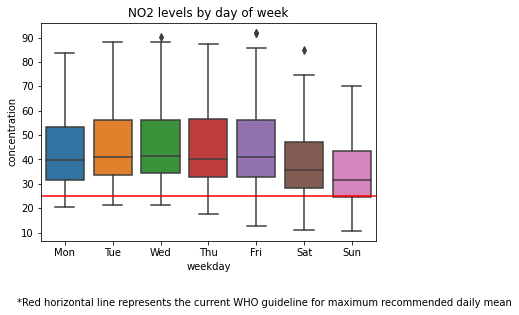

In [6]:
# Daily effects on NO2 levels
# Compute the average NO2 levels for each day of the week for each site
df = daily.groupby(["site_indicator", "weekday"]).agg("mean").reset_index()
sns.boxplot(x = "weekday", y="concentration", data = df, order=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.title("NO2 levels by day of week")
plt.axhline(rec_daily_max, color = 'r')
plt.text(-1,-20,'*Red horizontal line represents the current WHO guideline for maximum recommended daily mean')

Text(0, 0.5, 'NO2 (ug/m3)')

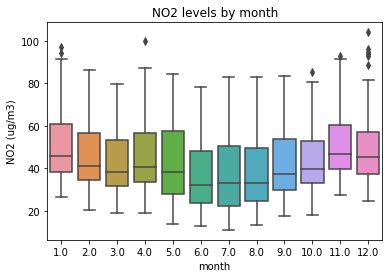

In [7]:
#monthly effects on NO2 levels
df = monthly.groupby(["site_indicator", "month"]).agg("mean").reset_index()
sns.boxplot(x = "month", y="concentration", data = df)
plt.title("NO2 levels by month")
plt.ylabel(pollutant_measure)

Text(0, 0.5, 'NO2 (ug/m3)')

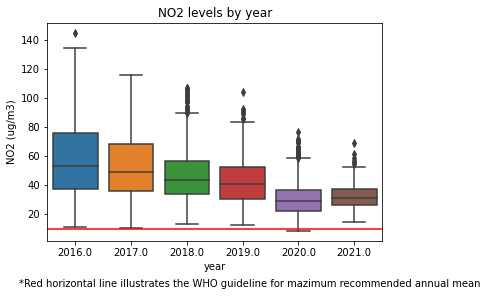

In [8]:
#year trends
#Compute yearly averages for each site 
df = monthly.groupby(["site_indicator", "month", "year"]).agg("mean").reset_index()
sns.boxplot(x = "year", y="concentration", data =df)
plt.title("NO2 levels by year")
plt.axhline(rec_yearly_max, color = 'r')
plt.text(-1,-30,'*Red horizontal line illustrates the WHO guideline for mazimum recommended annual mean') 
plt.ylabel(pollutant_measure)

Text(0, 0.5, 'NO2 (ug/m3)')

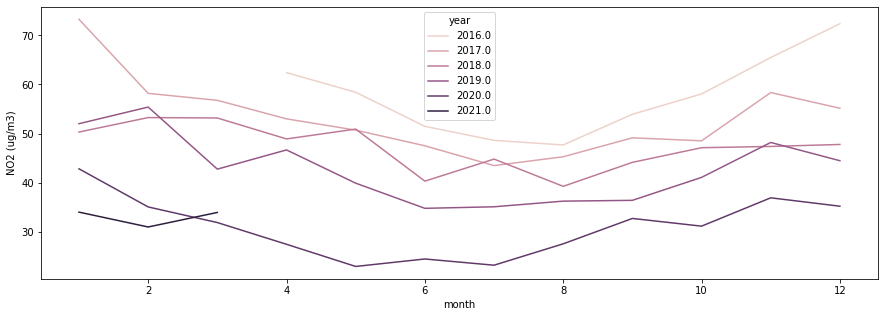

In [9]:
#By month for each year separately
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(ax = ax, data= df, x="month", y= "concentration", hue ="year",  ci = None)
ax.set_xlabel("month")
ax.set_ylabel(pollutant_measure)

### location effects on NO2

In [10]:
#Number of sites according to location and site type
print('number of sites with monthly data by location:')
monthly.groupby('location').agg("nunique")["site_indicator"]

number of sites with monthly data by location:


location
inside_border     11
on_border          8
outside_border    53
Name: site_indicator, dtype: int64

Examining the average monthly data according to site location relative to the charge zones reveals differences in NO2 concentrations between the three location categories (NO2 levels outside < border < inside the charge zone), with a decrease in NO2 concentrations visible over time across all locations. It is interesting to note a large drop in NO2 levels in March 2020, around the time when restrictions were introduced in London during the SARS-CoV-2 pandemic, followed by an upwards trend over time as restrictions were eased.

Text(0.5, 1.0, 'NO2 levels by time and location')

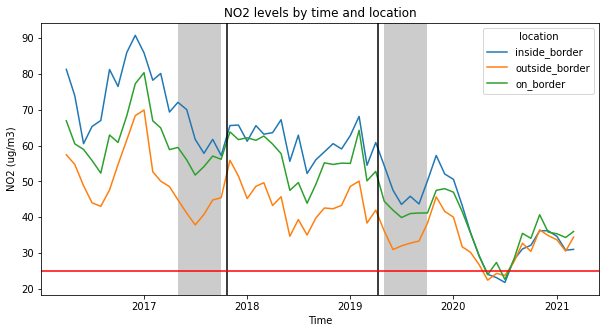

In [11]:
# Group the data by location type
df= monthly
df=df.reset_index()
df['MeasurementGMT'] = df['MeasurementGMT'].astype(str)
df['MeasurementGMT']= pd.to_datetime(df['MeasurementGMT'])
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(ax = ax, data=df, x="MeasurementGMT", y="concentration", hue ="location", ci = None) # can make the bars slimmer by adding ci=68
ax.set_xlabel("Time")
ax.set_ylabel(pollutant_measure)

#add line for t_charge and Ulez
plt.axvline(tc_start_date, color = 'k')
plt.axvline(ulez_start_date, color = 'k')

plt.axhline(rec_daily_max, color = 'r')
plt.axvspan("2017-05","2017-10", facecolor='k', alpha=0.2)
plt.axvspan("2019-05","2019-10", facecolor='k', alpha=0.2)
plt.title("NO2 levels by time and location")


-Red horizontal line illustrates the WHO guideline for maximum recommended daily mean.<br>
-Shaded grey areas represent time periods used to calculate average NO2 concentrations pre- and post-intervention (see analysis section below).<br>
-Vertical black lines represent the introduction of the T-Charge (2017) and ULEZ scheme (2019).

### Intervention effects on NO2

The EDA shows variations in NO2 concentrations due to factors that are unrelated to the toxicity charges. To examine the effects of the intervention, we now look at how NO2 levels change as a function of site location (i.e., inside the charge zone, on the border, and outside the charge zone).To minimise the influence of short-term and seasonality effects, we averaged the data over 6-month time periods, computing the average NO2 concentration pre-intervention (from May – October 2017), and post-intervention (from May-October 2019) for each site. These specific time periods were selected because they allowed us to include data after both the T-Charge and the ULEZ schemes were introduced in the post-intervention condition, while avoiding the inclusion of data that might be influenced by the covid pandemic. Sites that included less than 4 months of data to average over for the pre/post-intervention time periods were excluded from further analysis (leaving us with 7, 6, and 30 sites in the inside, border and outside groups respictively)

In [12]:
yearly_averages = pd.concat([pre_averages.reset_index(), post_averages.reset_index()])
#Number of sites according to location and site type
print('number of sites with pre- and post-intervention data by location:')
yearly_averages.groupby('location').agg("nunique")["site_indicator"]


number of sites with pre- and post-intervention data by location:


location
inside_border      7
on_border          6
outside_border    30
Name: site_indicator, dtype: int64

Text(0, 0.5, 'NO2 (ug/m3)')

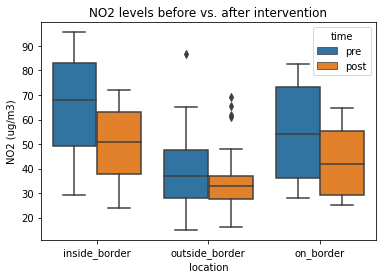

In [13]:
#Plot Pre vs post
sns.boxplot(x = "location", y="concentration", hue ="time", data =yearly_averages)
plt.title("NO2 levels before vs. after intervention")
plt.ylabel(pollutant_measure)

To detect changes that were the result of the traffic pollution charges, we calculate the average change that had occurred in NO2 concentration levels for each site. We compare the average change between sites grouped according to their location relative to the charge zones (inside, outside, and on the border). Our initial hypothesis was that we would find a difference in these deltas according to site location. Specifically, we had expected to see a larger reduction in NO2 levels within the charge zone compared to outside the charge zone. Furthermore, if our prediction that border roads might have suffered a negative impact as a result of the toxicity charge is correct, we would expect a smaller reduction in pollution for border sites compared to the sites outside the charge zone.  

In [14]:
# Display changes DF
changes.head()

,site_indicator,location,site_type,concentration,concentration_post,deltas,percent
0,BL0,inside_border,Urban Background,31.683530,23.885207,-7.798322,-24.613174
1,BT5,outside_border,Industrial,35.642602,32.729060,-2.913542,-8.174325
2,BT6,outside_border,Roadside,36.829901,30.100866,-6.729036,-18.270577
3,CD1,outside_border,Kerbside,47.383240,36.752767,-10.630473,-22.435091
4,CD9,on_border,Roadside,78.658534,64.824149,-13.834385,-17.587901


Text(0, 0.5, 'NO2 (ug/m3)')

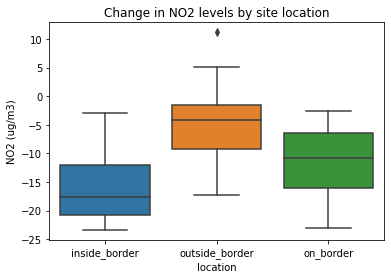

In [15]:
#Plot deltas by location
sns.boxplot(x = "location", y='deltas', data = changes)
plt.title("Change in NO2 levels by site location")
plt.ylabel(pollutant_measure)


We can see that the largest decrease in NO2 levels occured within the charge zone. However, the data does not seem to support our hypothesis, that the decrease would be smaller on the border areas compared to outside the zone. Below, we plot this data according to the percentage change, rather than concentration levels.

Text(0, 0.5, '% change')

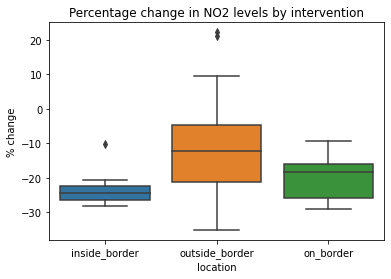

In [16]:
#Plot change in percentage by location
sns.boxplot(x = "location", y='percent', data = changes)
plt.title("Percentage change in NO2 levels by intervention")
plt.ylabel("% change")

## Statistical tests

A Kruskal-Wallis test showed a significant difference in the change in the NO2 concentration (i.e., the delta size) across the three location groups (inside, outside, and on the border of the toxicity charge zone; H = 11.75, p < .005, df  =2). Follow-up post-hoc comparisons revealed a significant difference between the change in NO2 for the inside sites compared to the outside sites ( p < .001). None of the other post-hoc comparisons are significant.


In [17]:
# Perform a Kruksall-Wallis comparing size of differences between the locations
delta_inside = changes.loc[changes.location == 'inside_border','deltas']
delta_outside = changes.loc[changes.location == 'outside_border', 'deltas']
delta_border = changes.loc[changes.location == 'on_border', 'deltas']
stat_3group, pval_3group = stats.kruskal(delta_inside, delta_outside, delta_border)

In [18]:
#Check whether the statistical test is significant
if pval_3group < .05:
    print('There is a significant difference between the groups')
print('the test statistic is:', stat_3group)
print('p =', pval_3group)

There is a significant difference between the groups
the test statistic is: 11.749078828148583
p = 0.0028100881835734187


In [19]:
#Since we found a significant difference between the groups we can
#run a post hoc Dunn test to look at directional differnces
if pval_3group < .05:
    print(sp.posthoc_dunn(changes, 'deltas','location', 'bonferroni' ))


                inside_border  on_border  outside_border
inside_border        1.000000   1.000000        0.005283
on_border            1.000000   1.000000        0.158921
outside_border       0.005283   0.158921        1.000000


In [20]:
# print percent of change within the toxicity charge zone
print ('The change witihn the toxicity charge zone is:', round(changes.loc[changes.location == 'inside_border','percent'].mean()), '%')

The change witihn the toxicity charge zone is: -23 %


## Conclusions

These results demonstrate that the toxicity charges led to a decrease in NO2 concentrations in areas within the intervention zone. Furthermore, we found that the reduction was comparable in size to the effect reported by the Mayor of London (23% reduction in our analysis, vs. 24%-29% reported by the Mayor of London). However, we did not find support for our prediction that areas on the border would suffer negative results. 

Despite the decrease in some pollutants, levels of NO2 in London are still vastly above the WHO recommendations. Further work is needed to continue the reduction of air pollutants, to improve the safety and health of London residents.


*This analysis was part of the DS4A/Women's program.